<p><font size="6" color='grey'> <b>
Machine Learning
</b></font> </br></p>
<p><font size="5" color='grey'> <b>
Time Series Analysis  - Recurrent Neural Network & LSTM - Weather Australia
</b></font> </br></p>

---

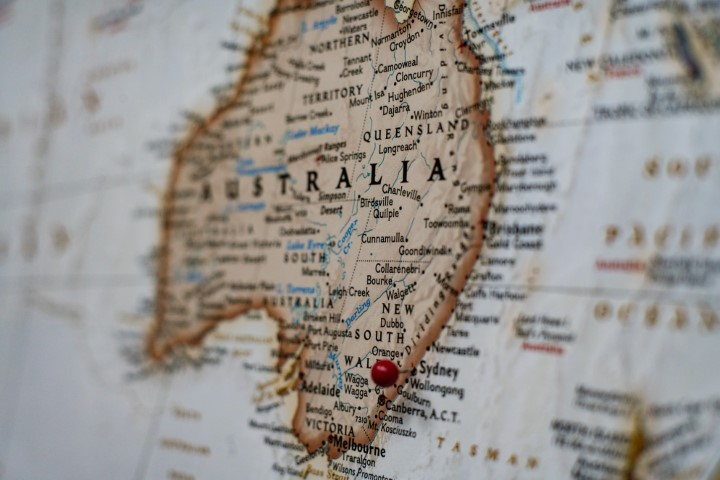

Foto von <a href="https://unsplash.com/@joey_csunyo?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Joey Csunyo</a> auf <a href="https://unsplash.com/de/fotos/2EGuIR00UTk?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>
  
  

# **1 <font color='orange'>|</font> Understand**
---

<p><font color='black' size="5">
Warnungen ausschalten
</font></p>

In [365]:
import warnings
warnings.filterwarnings('ignore')

<p><font color='black' size="5">
Anwendungsfall
</font></p>

---   


Dieser Datensatz enthält ungefähr 10 Jahre täglicher Wetterbeobachtungen von vielen Orten in ganz Australien.

Die `Mittlere Temperatur` ist die vorherzusagende Zielvariable. Es bedeutet – wie hoch ist die durchschnittliche Monatstemperatur im nächsten Monat.

Prognostizieren die `Mittlere Temperatur`, indem Sie das Modelle mit der Zielvariablen trainieren.


[Info](https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package)

[DataSet](https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package)





In [366]:
import pandas as pd
import numpy as np

In [367]:
# from google.colab import drive
# drive.mount('/content/drive')
# data = pd.read_csv(
#     '/content/drive/MyDrive/ml-kurs/02 data/Wheather_Hobart.csv',
#     sep=';',
#     usecols=['Date', 'MinTemp', 'MaxTemp'],
#     parse_dates=['Date'],
#     dayfirst=True
# )

In [368]:
data = pd.read_csv(
    'https://raw.githubusercontent.com/ralf-42/ml-kurs/main/02%20data/Wheather_Hobart.csv',
    sep=';',
    usecols=['Date', 'MinTemp', 'MaxTemp'],
    parse_dates=['Date'],
    dayfirst=True
)

# **2 <font color='orange'>|</font> Prepare**
---


<p><font color='black' size="5">
Ermittlung Jahr-Monat aus dem Datum
</font></p>

In [369]:
data['YearMonth'] = data['Date'].dt.to_period('M')

<p><font color='black' size="5">
Missing Values
</font></p>

In [370]:
data.fillna(method='ffill', inplace=True)

In [371]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3193 entries, 0 to 3192
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       3193 non-null   datetime64[ns]
 1   MinTemp    3193 non-null   int64         
 2   MaxTemp    3193 non-null   float64       
 3   YearMonth  3193 non-null   period[M]     
dtypes: datetime64[ns](1), float64(1), int64(1), period[M](1)
memory usage: 99.9 KB


<p><font color='black' size="5">
Ermittlung der Durchschnittstemperatur & Gruppierung
</font></p>

In [372]:
data['MedTemp'] = data[['MinTemp', 'MaxTemp']].mean(axis=1)

In [373]:
data = data.groupby('YearMonth')['MedTemp'].mean().to_frame()

In [374]:
data.index = data.index.to_timestamp()

<p><font color='black' size="5">
EDA (Exploratory Data Analysis)   
</font></p>

<p><font color='black' size="4">
Visualisierung der Daten
</font></p>

In [375]:
import plotly.express as px
fig = px.line(data, title="Australien Weather", width=1200, height=500)
fig.show()

<p><font color='black' size="4">
Statistische Analyse
</font></p>

In [376]:
%%capture
try:
  from scalecast.Forecaster import Forecaster
except:
  !pip install -q scalecast
  from scalecast.Forecaster import Forecaster

In [377]:
from scalecast.Forecaster import Forecaster
f = Forecaster(
    y=data['MedTemp'],
    current_dates=data.index,
    # test_length = 24,
    # future_dates = 1,
    # cis = True,
)

<p><font color='black' size="4">
Decomposition der Zeitreihen
</font></p>

**Trend:** Der zugrundeliegende Trend in den Daten. Dies ist das Ergebnis der Glättung der Daten, um langfristige Änderungen zu identifizieren.    

**Saisonale Komponente:** Die regelmäßigen Schwankungen in den Daten, die auf jährlichen, monatlichen, wöchentlichen oder anderen regelmäßigen Zyklen zurückzuführen sein können.

**Residuen (Reste):** Das ist das, was übrig bleibt, nachdem der Trend und die saisonale Komponente aus den ursprünglichen Daten entfernt wurden.

Beobachtete Werte: Die ursprünglichen Datenpunkte der Zeitreihe.

In [378]:
import matplotlib.pyplot as plt

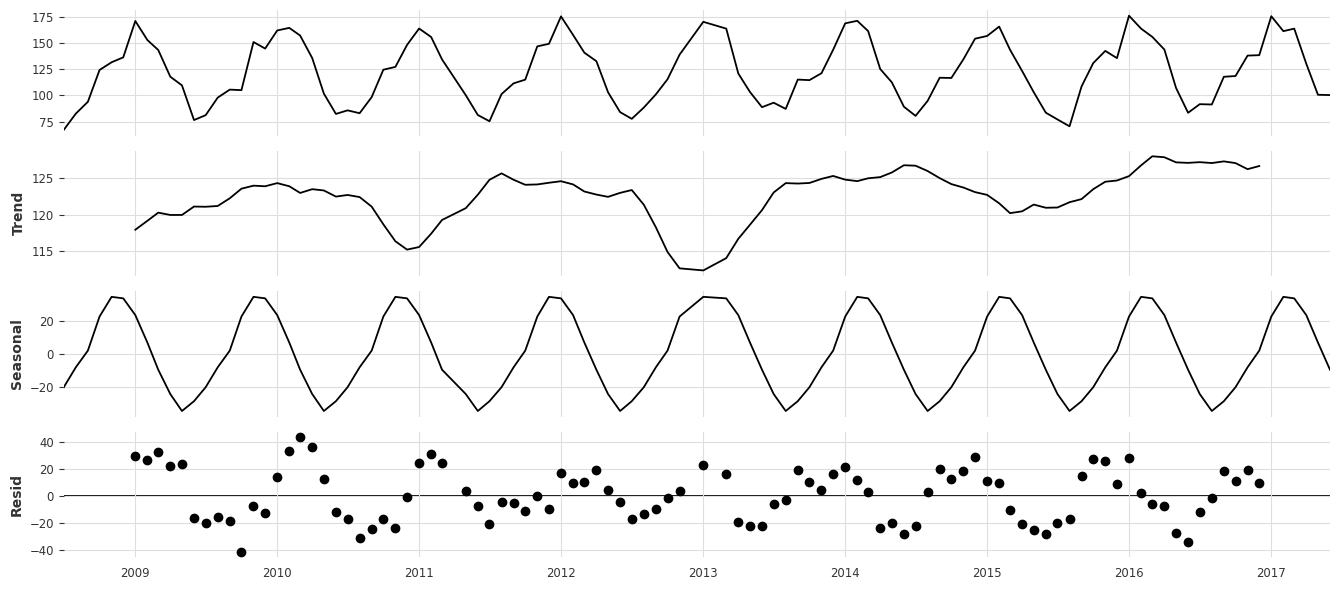

In [379]:
plt.rc("figure",figsize=(13.5,6))
f.seasonal_decompose(period=12).plot() # Fehlermeldung ohne period=12
plt.show()

In [380]:
del f

In [381]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 105 entries, 2008-07-01 to 2017-06-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   MedTemp  105 non-null    float64
dtypes: float64(1)
memory usage: 1.6 KB


# **3 <font color='orange'>|</font> Modeling**
---

<p><font color='black' size="5">
Übergreifende Parameter
</font></p

In [436]:
epochs_ = 100
num_features_ = 1
look_back_ = 12

In [437]:
import tensorflow as tf
tf.keras.utils.set_random_seed(42)

In [438]:
#@title
#@markdown <p><font size="5" color='grey'> <b> Function create_dataset  alternativ zu TimeseriesGenerator</b></font> </br></p>
def create_dataset(x, y, time_step = 12):
  xs,ys = [] , []
  for i in range(len(x) - time_step):
    v = x.iloc[i:(i + time_step)].values
    xs.append(v)
    ys.append(y.iloc[i + time_step])
  return np.array(xs), np.array(ys)

In [439]:
data_, target_ = create_dataset(data, data, look_back_)

In [440]:
from sklearn.model_selection import train_test_split
data_train, data_test, target_train, target_test = train_test_split(data_, target_, test_size=0.2, shuffle=False)
data_train.shape, data_test.shape, target_train.shape, target_test.shape

((74, 12, 1), (19, 12, 1), (74, 1), (19, 1))

In [441]:
del data_, target_

<p><font color='black' size="5">
Schrittweise Modellierung eines Neuronalen Netzes
</font></p>

[Core layers](https://keras.io/api/layers/core_layers/)    
[Recurrent layers](https://keras.io/api/layers/recurrent_layers/)   
[Layer activation functions](https://keras.io/api/layers/activations/)   


In [442]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input

In [443]:
import tensorflow as tf
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

In [444]:
model = Sequential(name="Weather_RNN_LSTM")
model.add(Input(shape=(look_back_, num_features_)))
model.add(LSTM(128,activation = 'relu', return_sequences=True))
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(LSTM(128, activation='relu', return_sequences=False))
model.add(Dense(1))

In [445]:
model.compile(optimizer='adam', loss='mae', metrics=[tf.keras.metrics.MeanAbsolutePercentageError()])

<p><font color='black' size="5">
Einfaches Layer-Diagramm
</font></p>

In [446]:
model.summary()

Model: "Weather_RNN_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_86 (LSTM)              (None, 12, 128)           66560     
                                                                 
 lstm_87 (LSTM)              (None, 12, 128)           131584    
                                                                 
 lstm_88 (LSTM)              (None, 128)               131584    
                                                                 
 dense_30 (Dense)            (None, 1)                 129       
                                                                 
Total params: 329857 (1.26 MB)
Trainable params: 329857 (1.26 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


<p><font color='black' size="5">
Training
</font></p>

**Callback**

Ein Callback ist ein Objekt, das Aktionen in verschiedenen Stadien des Trainings ausführen kann (z. B. zu Beginn oder am Ende einer Epoche, vor oder nach einem einzelnen Stapel usw.).

Sie können Rückrufe verwenden, um:

+ Schreiben Sie nach jedem Trainingsstapel TensorBoard-Protokolle, um Ihre Metriken zu überwachen
+ Speichern Sie Ihr Modell regelmäßig auf der Festplatte
+ Machen Sie frühzeitig Schluss
+ Verschaffen Sie sich während des Trainings einen Überblick über interne Zustände und Statistiken eines Modells
+ ...

In [447]:
# callback für learning-rate-scheduler
epochs_decr = int(epochs_* 0.15)
def scheduler(epoch, lr):
  lr_new = lr
  if epoch >= epochs_decr:
    lr_new *= tf.math.exp(-0.1)
  return lr_new

learning_rate_callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=True)

In [448]:
%%time
model.fit(data_train, target_train, epochs=epochs_, callbacks=[learning_rate_callback])


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/100
3/3 [==============================] - 5s 365ms/step - loss: 102.1113 - mean_absolute_percentage_error: 83.1908 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/100
3/3 [==============================] - 0s 49ms/step - loss: 43.0092 - mean_absolute_percentage_error: 37.2180 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/100
3/3 [==============================] - 0s 49ms/step - loss: 16.9604 - mean_absolute_percentage_error: 14.5157 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/100
3/3 [==============================] - 0s 49ms/step - loss: 27.3930 - mean_absolute_percentage_error: 23.7487 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 5/100
3/3 [==============================] - 0s 57ms

In [449]:
print(model.history.params)
print(model.history.history.keys())

{'verbose': 1, 'epochs': 100, 'steps': 3}
dict_keys(['loss', 'mean_absolute_percentage_error', 'lr'])


<p><font color='black' size="5">
Loss-Entwickung
</font></p>

In [450]:
import plotly.express as px
title_ = 'Loss-Entwicklung'
px.line(y=model.history.history['loss'], title=title_, labels={'x':'Epochen', 'y':'Loss-Wert'}, width=800, height=400)

# **4 <font color='orange'>|</font> Evaluate**
---

<p><font color='black' size="5">
Prognose der Trainingsdaten
</font></p>

In [451]:
# train_pred = model.predict(generator)
target_train_pred = model.predict(data_train)

3/3 [==============================] - 1s 510ms/step


<p><font color='black' size="5">
Bestimmheitsmass Train
</font></p>

In [452]:
from sklearn.metrics import r2_score
r2 = r2_score(target_train, target_train_pred)
print(f'Bestimmtheitsmass -- Train --: {r2:5.2f}' )

Bestimmtheitsmass -- Train --:  0.89


<p><font color='black' size="5">
Prognose der Testdaten
</font></p>

In [453]:
# Die letzten x Wochen (look_back) sind der Aufsetzpunkt für die erste Prognose
target_test_pred = target_train[-look_back_:]

In [454]:
# Anpassung Dimensionen, wie von RNN/LSTM erwartet (analog TimeseriesGeneration, siehe oben)
current_batch = target_test_pred.reshape((1,look_back_, num_features_))

In [455]:
# rollierender Forecast
for i in range(len(target_test)):
    pred = model.predict(current_batch)[0]
    target_test_pred = np.append(target_test_pred, float(pred))
    current_batch = target_test_pred[-look_back_:].reshape((1,look_back_, 1))

1/1 [==============================] - 0s 33ms/step


In [456]:
# Löschen der look-back Wochen, die aus den Trainingsdaten, die für die 1. Prognose übernommen wurden (siehe oben)
target_test_pred = target_test_pred[look_back_:]

<p><font color='black' size="5">
Graphische Aufbereitung der Ergebnisse
</font></p>

In [457]:
result = data[-len(target_test):].copy()
result = result.reset_index()

In [458]:
result['LSTM'] = pd.DataFrame(target_test_pred)

In [459]:
fig = px.line(result, x='YearMonth', y=['MedTemp', 'LSTM'], title="Australian Weather - Real vs. Forecast", width=1200, height=500)
fig.show()

# **5 <font color='orange'>|</font> Deploy**
---

<p><font color='black' size="5">📋 Checkliste</font></p>

✅ Modellexport und -speicherung</br>
✅ Abhängigkeiten und Umgebung</br>
✅ Sicherheit und Datenschutz</br>
✅ In die Produktion integrieren</br>
✅ Tests und Validierung</br>
✅ Dokumentation & Wartung</br>

# **A <font color='orange'>|</font> SARIMA**
---

[SARIMA](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html)


**trend**
Parameter, der das deterministische Trendpolynom steuert
. Kann als Zeichenkette angegeben werden, wobei „c“ eine Konstante angibt (dh eine Komponente vom Grad Null des Trendpolynoms), „t“ einen linearen Trend mit der Zeit angibt und „ct“ beides ist. Kann auch als Iterable angegeben werden, das die einzubeziehenden Polynomexponenten ungleich null in aufsteigender Reihenfolge definiert. Beispielsweise bezeichnet [1,1,0,1].
. Standardmäßig ist keine Trendkomponente enthalten.

**order**
Die (p,d,q)-Ordnung des Modells für die Anzahl der AR-Parameter, Differenzen und MA-Parameter. d muss eine ganze Zahl sein, die die Integrationsreihenfolge des Prozesses angibt, während p und q entweder ganze Zahlen sein können, die die AR- und MA-Reihenfolgen angeben (so dass alle Verzögerungen bis zu diesen Reihenfolgen enthalten sind) oder Iterables, die spezifische AR und / oder MA angeben Verzögerungen einzubeziehen. Standard ist ein AR(1)-Modell: (1,0,0).

**seasonal_order**
Die (P,D,Q,s)-Reihenfolge der saisonalen Komponente des Modells für die AR-Parameter, Differenzen, MA-Parameter und Periodizität. D muss eine ganze Zahl sein, die die Integrationsreihenfolge des Prozesses angibt, während P und Q entweder ganze Zahlen sein können, die die AR- und MA-Reihenfolge angeben (so dass alle Verzögerungen bis zu diesen Reihenfolgen enthalten sind) oder andernfalls Iterables, die spezifische AR und / oder MA angeben Verzögerungen einzubeziehen. s ist eine ganze Zahl, die die Periodizität (Anzahl der Saisonperioden) angibt, oft ist es 4 für vierteljährliche Daten oder 12 für monatliche Daten. Standard ist kein saisonaler Effekt.

In [460]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

<p><font color='black' size="5">
Modellbildung, Training, Prognose
</font></p>

In [461]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [462]:
# --- Initalisierung der Variablen

data_list = data['MedTemp'].values
size = len(data_list) - len(target_test_pred)
data_train_list, data_test_list = data_list[0:size], data_list[size:len(data_list)]
history = [x for x in data_train_list]
predictions = list()

In [463]:
# --- Modelldefinition & Training

model_sarima = SARIMAX(history, trend='n', order=(1,1,1), seasonal_order=(2,0,2,12))
model_sarima = model_sarima.fit(disp=0)

In [464]:
# --- rollierende Prognose ab Zeitpunkt Trainingsende

for t in range(len(data_test_list)):
	output = model_sarima.predict(start=len(history), end=len(history))
	yhat = output[0]
	predictions.append(yhat)
	# obs = data_test_list[t]		# yhat anstelle obs in Zeile 15
	history.append(yhat)

<p><font color='black' size="5">
Graphische Aufbereitung der Ergebnisse
</font></p>

In [465]:
RollBack =  data[size:len(data)]
RollBack['SARIMA']= predictions
RollBack.head()

,MedTemp,SARIMA
YearMonth,,
2015-12-01,135.693548,152.274040
2016-01-01,176.225806,155.724640
2016-02-01,163.896552,156.156046
2016-03-01,155.967742,142.954057
2016-04-01,143.866667,106.416136


In [466]:
fig = px.line(RollBack, title="Australien Beer Production - Real Production vs Forecast", width=1200, height=500)
fig.show()

In [467]:
RollBack['LSTM']= target_test_pred
RollBack.head()

,MedTemp,SARIMA,LSTM
YearMonth,,,
2015-12-01,135.693548,152.274040,154.273300
2016-01-01,176.225806,155.724640,154.826691
2016-02-01,163.896552,156.156046,148.447403
2016-03-01,155.967742,142.954057,137.910309
2016-04-01,143.866667,106.416136,109.747932


In [468]:
fig = px.line(RollBack, title="Weather - Real Production vs Forecast", width=1200, height=500)
fig.show()

In [469]:
#@title
#@markdown <p><font size="5" color='grey'> <b> Bestimmung der besten Parameter

# [Quelle](https://medium.com/towards-data-science/how-to-forecast-sales-with-python-using-sarima-model-ba600992fa7d)

# import itertools
# p = d = q = range(0, 3)
# pdq = list(itertools.product(p, d, q))
# seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
# print('Examples of parameter for SARIMA...')
# print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
# print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
# print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
# print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

# param_search = pd.DataFrame(columns=['param', 'param_seasonal', 'aic'])

# for param in pdq:
#     for param_seasonal in seasonal_pdq:
#         try:
#             mod = SARIMAX(history,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
#             results = mod.fit()
#             # print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))
#             param_search = param_search.append({'param':param,'seasonal':param_seasonal ,'AIC': results.aic}, ignore_index = True)
#         except:
#             continue

# results.plot_diagnostics(figsize=(18, 8))
# plt.show()

# Neues Modell

In [470]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input
import plotly.express as px

# Daten laden
# file_path = 'Ihr_Dateipfad_hier.csv'  # Ersetzen Sie dies durch Ihren Dateipfad
# data_df = pd.read_csv(file_path)
# data_df['YearMonth'] = pd.to_datetime(data_df['YearMonth'])
# data_df.set_index('YearMonth', inplace=True)

# Datenvorbereitung
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Hilfsfunktion zur Erstellung von Trainings- und Testdaten
def create_dataset(data, n_past_steps):
    data_arr, target_arr = [], []
    for i in range(n_past_steps, len(data)):
        data_arr.append(data[i - n_past_steps:i, 0])
        target_arr.append(data[i, 0])
    return np.array(data_arr), np.array(target_arr)

n_past_steps = 12  # Anzahl der Schritte, die zur Vorhersage der Zukunft verwendet werden

# Trainings- und Testdaten aufteilen
train_data, test_data = train_test_split(data_scaled, test_size=0.2, shuffle=False)

train_data, train_target = create_dataset(train_data, n_past_steps)
test_data, test_target = create_dataset(test_data, n_past_steps)

# Umformung für das LSTM-Modell
train_data = np.reshape(train_data, (train_data.shape[0], train_data.shape[1], 1))
test_data = np.reshape(test_data, (test_data.shape[0], test_data.shape[1], 1))


In [471]:
# LSTM-Modell
model = Sequential()
model.add(Input(shape=(n_past_steps, 1)))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(128))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mae')


# Modelltraining
model.fit(train_data, train_target, epochs=100, verbose=1)

Epoch 1/100
3/3 [==============================] - 9s 1s/step - loss: 0.4249
Epoch 2/100
3/3 [==============================] - 0s 49ms/step - loss: 0.2552
Epoch 3/100
3/3 [==============================] - 0s 77ms/step - loss: 0.2672
Epoch 4/100
3/3 [==============================] - 0s 78ms/step - loss: 0.2775
Epoch 5/100
3/3 [==============================] - 2s 1s/step - loss: 0.2886
Epoch 6/100
3/3 [==============================] - 0s 80ms/step - loss: 0.2530
Epoch 7/100
3/3 [==============================] - 0s 93ms/step - loss: 0.2467
Epoch 8/100
3/3 [==============================] - 0s 47ms/step - loss: 0.2433
Epoch 9/100
3/3 [==============================] - 2s 835ms/step - loss: 0.2331
Epoch 10/100
3/3 [==============================] - 0s 44ms/step - loss: 0.2377
Epoch 11/100
3/3 [==============================] - 0s 46ms/step - loss: 0.2362
Epoch 12/100
3/3 [==============================] - 0s 44ms/step - loss: 0.2288
Epoch 13/100
3/3 [==============================] - 

In [472]:
print(model.history.params)
print(model.history.history.keys())

{'verbose': 1, 'epochs': 100, 'steps': 3}
dict_keys(['loss'])


In [473]:
results = model.history.history.copy()

<p><font color='black' size="5">
Loss-Entwickung
</font></p>

In [474]:
import plotly.express as px
title_ = 'Loss-Entwicklung'
px.line(y=results['loss'], title=title_, labels={'x':'Epochen', 'y':'Loss-Wert'}, width=800, height=400)

In [475]:
# Rollierende Prognose
n_future_steps = len(test_target)  # Anzahl der Schritte in die Zukunft
letzte_train_daten = train_data[-1]  # Letzte bekannte Trainingsdaten
aktuelle_eingabe = np.array([letzte_train_daten])

prognosen = []
for i in range(n_future_steps):
    # Mache eine Vorhersage mit den aktuellen Eingabedaten
    prognose = model.predict(aktuelle_eingabe)

    # Füge die Vorhersage zu den Prognosen hinzu
    prognosen.append(prognose[0,0])

    # Aktualisiere die Eingabedaten, um die neue Vorhersage einzubeziehen
    prognose_angepasst = np.reshape(prognose, (1, 1, 1))
    aktuelle_eingabe = np.append(aktuelle_eingabe[:,1:,:], prognose_angepasst, axis=1)

# Umkehren der Normalisierung
prognosen = scaler.inverse_transform([prognosen])
test_target_actual = scaler.inverse_transform([test_target])

1/1 [==============================] - 0s 40ms/step


In [477]:
# Visualisierung der rollierenden Vorhersagen im Vergleich zu den tatsächlichen Werten
dates = data.index[-len(test_target):]
fig = px.line(title='Vorhersage vs Tatsächliche Werte', width=1200, height=600)
fig.add_scatter(x=dates, y=test_target_actual[0], mode='lines', name='Tatsächliche Werte')
fig.add_scatter(x=dates, y=prognosen[0], mode='lines', name='Rollierende Vorhersagen')
fig.update_layout(xaxis_title='Datum', yaxis_title='Temperatur', legend_title='Legende',
                  yaxis=dict(range=[0, max(max(test_target_actual[0]), max(prognosen[0]))]))
fig.show()